In [4]:
import numpy as np
import tensorflow as tf


2023-04-25 14:31:33.092668: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
import pathlib
root_dir = './dataset-Simpsons_Main_Characters/'
train_dir = pathlib.Path(root_dir + 'train_images/')
test_dir = pathlib.Path(root_dir + 'test_images/')

In [7]:
# Total number of images in the training dataset

image_count = len(list(train_dir.glob('*/*.jpg')))
image_count

6936

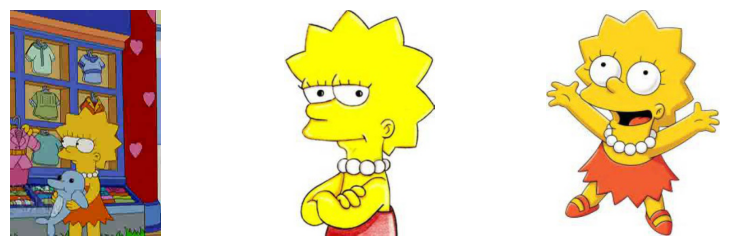

In [8]:
# Visualize
import matplotlib.pyplot as plt
import PIL
pic_lisa = list(train_dir.glob('lisa_simpson/*.jpg'))

plt.figure(figsize=(10, 10))

for i in range(3):
    plt.subplot(3, 3, i + 1)
    img = PIL.Image.open(str(pic_lisa[i]))
    plt.imshow(img)
    plt.axis('off')

plt.show()

In [103]:
# Setup of variablesdock
batch_size = 32
img_height = 224
img_width = 224

In [104]:
# Gathering information
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 6936 files belonging to 5 classes.
Using 5549 files for training.


In [105]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 6936 files belonging to 5 classes.
Using 1387 files for validation.


In [106]:
# Visualisation according to the classes
class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)

for images, labels in train_ds.take(1):
    print(labels)
    print(labels[10])
    print(class_names[labels[10]])

['bart_simpson', 'homer_simpson', 'lisa_simpson', 'maggie_simpson', 'marge_simpson']


2023-04-25 17:29:16.390494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [5549]
	 [[{{node Placeholder/_4}}]]
2023-04-25 17:29:16.391523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5549]
	 [[{{node Placeholder/_0}}]]


tf.Tensor([3 2 0 3 4 1 1 1 1 3 2 2 3 4 2 3 1 1 1 3 1 3 2 1 2 1 4 4 1 1 4 2], shape=(32,), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
lisa_simpson


2023-04-25 17:29:19.660101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [5549]
	 [[{{node Placeholder/_4}}]]
2023-04-25 17:29:19.660694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5549]
	 [[{{node Placeholder/_0}}]]


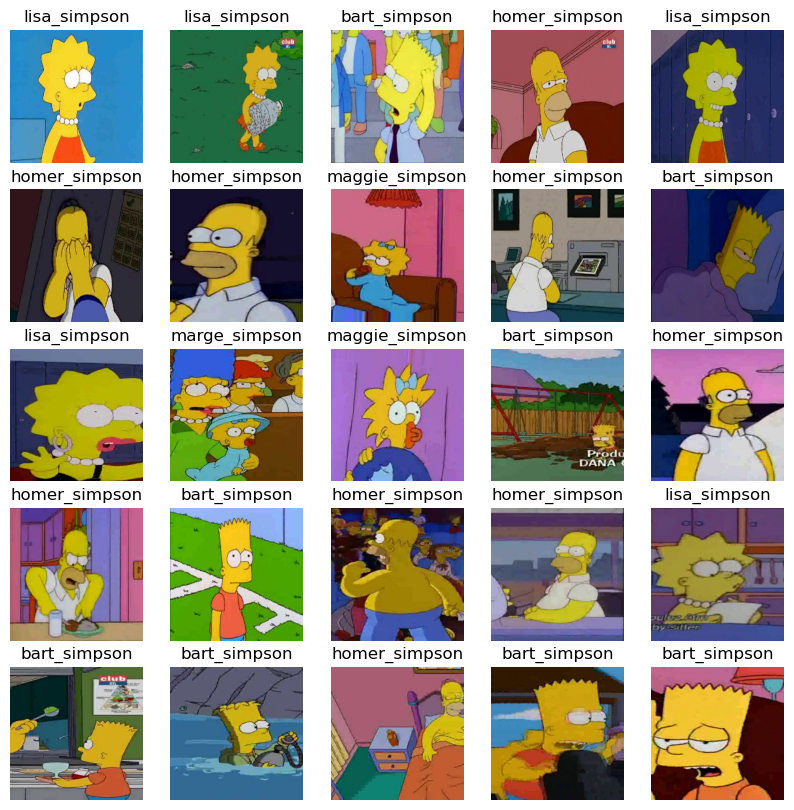

In [107]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [111]:
# Pre-processing / setting up the base model
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [110]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [112]:
preprocess_input = tf.keras.applications.resnet.preprocess_input

In [113]:
# Transfer learning using the ResNEt model
base_model = tf.keras.applications.resnet.ResNet50(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)

In [114]:
base_model.trainable = False

In [115]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_classes)

In [116]:
# Building Model
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [117]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [118]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0   

In [119]:
# Training the model
model.evaluate(val_ds)

2023-04-25 17:30:38.661864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1387]
	 [[{{node Placeholder/_4}}]]
2023-04-25 17:30:38.662738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1387]
	 [[{{node Placeholder/_4}}]]


44/44 [==============================] - 109s 2s/step - loss: 2.2804 - accuracy: 0.1442


[2.2803964614868164, 0.14419610798358917]

In [126]:
epochs = 25

history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds
)

Epoch 1/25
174/174 [==============================] - 598s 3s/step - loss: 0.6426 - accuracy: 0.7684 - val_loss: 0.5154 - val_accuracy: 0.8291
Epoch 2/25
174/174 [==============================] - 660s 4s/step - loss: 0.6317 - accuracy: 0.7758 - val_loss: 0.5168 - val_accuracy: 0.8313
Epoch 3/25
174/174 [==============================] - 653s 4s/step - loss: 0.6190 - accuracy: 0.7832 - val_loss: 0.5115 - val_accuracy: 0.8183
Epoch 4/25
174/174 [==============================] - 736s 4s/step - loss: 0.6198 - accuracy: 0.7846 - val_loss: 0.5008 - val_accuracy: 0.8255
Epoch 5/25
174/174 [==============================] - 691s 4s/step - loss: 0.6049 - accuracy: 0.7924 - val_loss: 0.4895 - val_accuracy: 0.8349
Epoch 6/25
174/174 [==============================] - 645s 4s/step - loss: 0.5901 - accuracy: 0.7953 - val_loss: 0.4711 - val_accuracy: 0.8486
Epoch 7/25
174/174 [==============================] - 678s 4s/step - loss: 0.5839 - accuracy: 0.7897 - val_loss: 0.4703 - val_accuracy: 0.8464

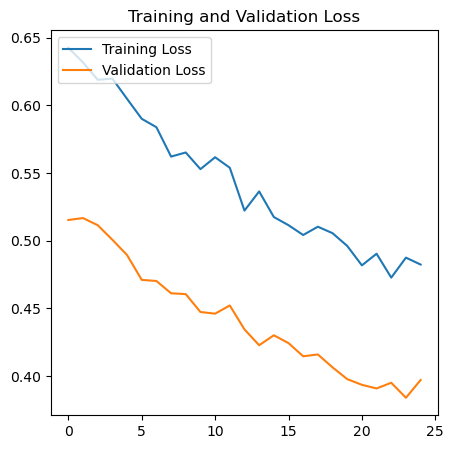

In [161]:



# Visualization of Accuracy and loss
# Loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(5, 5))
plt.plot(epochs_range, train_loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')

plt.show()

In [128]:
val_loss = history.history['val_loss']
print(val_loss)

[0.5153701901435852, 0.5167655348777771, 0.511524498462677, 0.5007560849189758, 0.48945844173431396, 0.4711189866065979, 0.47028371691703796, 0.46122172474861145, 0.4605781137943268, 0.44738101959228516, 0.4461544454097748, 0.45220133662223816, 0.43453511595726013, 0.42282822728157043, 0.43017882108688354, 0.4244050681591034, 0.4146537184715271, 0.4159957468509674, 0.4064840078353882, 0.3977912366390228, 0.3935808837413788, 0.3908863067626953, 0.3951064944267273, 0.38400283455848694, 0.3971538245677948]


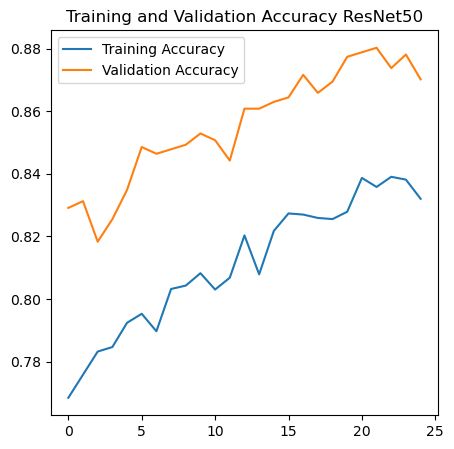

In [149]:
# Accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs_range = range(epochs)

plt.figure(figsize=(5, 5))
plt.plot(epochs_range, train_acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy ResNet50')

plt.show()

In [130]:
# Validation data set with visualisation to check the prediction
def predict(model, img):
    img_array = tf.keras.utils.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 0)
    return predicted_class, confidence

2023-05-02 09:03:53.605394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1387]
	 [[{{node Placeholder/_4}}]]
2023-05-02 09:03:53.610772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1387]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 241ms/step


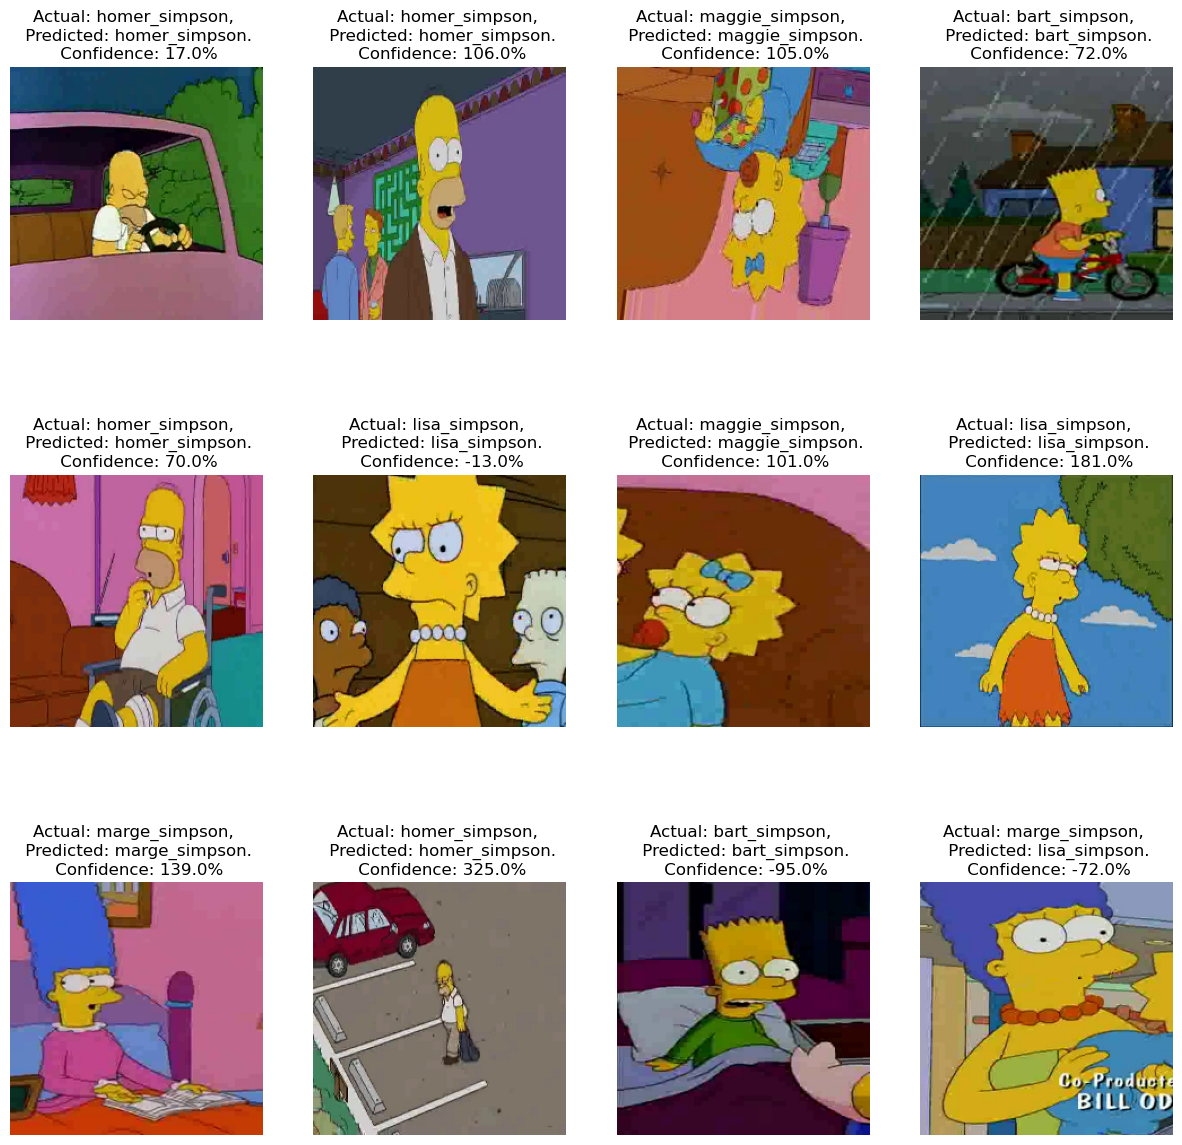

In [152]:
plt.figure(figsize=(15, 15))
for images, labels in val_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis('off')

In [170]:
#图片测试


test_root = './test/'
# Load the model from the file
from_model = model
IMG_WIDTH = 224
IMG_HEIGHT = 224


In [171]:
from keras import metrics

In [172]:
test_datagen = ImageDataGenerator(
    rescale=1. / 255
)
test_genertor = test_datagen.flow_from_directory(
    test_root,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=batch_size,
)

result = from_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc', metrics.Precision(), metrics.Recall()])

Found 5 images belonging to 5 classes.


In [175]:
model.evaluate(test_genertor, 
               max_queue_size=10, workers=1, use_multiprocessing=False, verbose=1)



2023-05-02 09:18:28.897525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 390ms/step - loss: 6.9868 - acc: 0.2000 - precision: 0.2000 - recall: 0.4000


[6.9867963790893555,
 0.20000000298023224,
 0.20000000298023224,
 0.4000000059604645]

In [177]:
NB_CLASS = 5
# confusion matrix
display_labels = range(0, NB_CLASS)

In [178]:
show_figure = False
normalization = True

In [179]:
def test(picname, model):
    keras.backend.clear_session()
    img_path = picname
    test_image = image.load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)
    test_image_test_image/255
    predict = model.predict(tesy_image)
    preds = np.argmax(predict, axis=1)[0]
    return preds

In [180]:
test_gen = test_datagen.flow_from_directory(test_root, target_size=(IMG_WIDTH, IMG_HEIGHT))
print(test_gen.class_indices)


Found 5 images belonging to 5 classes.
{'bart_simpson': 0, 'homer_simpson': 1, 'lisa_simpson': 2, 'maggie_simpson': 3, 'marge_simpson': 4}


min: 0.0 max: 1.0


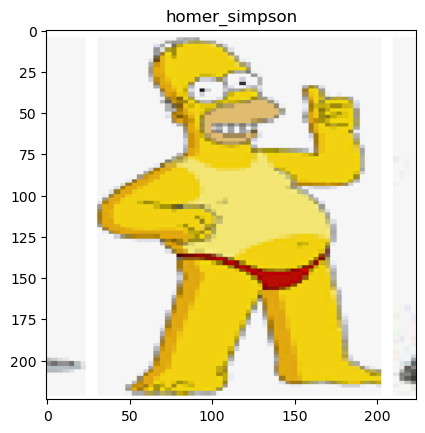

['bart_simpson', 'homer_simpson', 'lisa_simpson', 'maggie_simpson', 'marge_simpson']


In [181]:
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
    labels[v] = k

# should be a strangely colored image (due to VGG weights being BGR)
for x, y in test_gen:
    print("min:", x[0].min(), "max:", x[0].max())
    plt.title(labels[np.argmax(y[0])])
    plt.imshow(x[0])
    plt.show()
    break
print(labels)


In [182]:
import itertools


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.rcParams["figure.figsize"] = (40,20)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")
  
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [185]:
import os
import json
import glob
from prettytable import PrettyTable





class ConfusionMatrix(object):
    def __init__(self, num_classes: int, labels: list):
        self.matrix = np.zeros((num_classes, num_classes))
        self.num_classes = num_classes
        self.labels = labels

    def update(self, preds, labels):
        for p, t in zip(preds, labels):
            self.matrix[p, t] += 1

    def summary(self):
        # calculate accuracy
        sum_TP = 0
        for i in range(self.num_classes):
            sum_TP += self.matrix[i, i]
        acc = sum_TP / np.sum(self.matrix)
        print("the model accuracy is ", acc)

        # precision, recall, specificity
        table = PrettyTable()
        table.field_names = ["", "Precision", "Recall", "Specificity", 'F1']
        for i in range(self.num_classes):
            TP = self.matrix[i, i]
            FP = np.sum(self.matrix[i, :]) - TP
            FN = np.sum(self.matrix[:, i]) - TP
            TN = np.sum(self.matrix) - TP - FP - FN
            Precision = round(TP / (TP + FP), 3) if TP + FP != 0 else 0.
            Recall = round(TP / (TP + FN), 3) if TP + FN != 0 else 0.
            Specificity = round(TN / (TN + FP), 3) if TN + FP != 0 else 0.
            F1 = round(2*Precision*Recall/(Precision+Recall), 3) if Precision+Recall != 0 else 0.
            table.add_row([self.labels[i], Precision, Recall, Specificity, F1])
        print(table)

    def plot(self):
        matrix = self.matrix
        print(matrix)
        plt.imshow(matrix, cmap=plt.cm.Blues)

        plt.xticks(range(self.num_classes), self.labels, rotation=45)
        plt.yticks(range(self.num_classes), self.labels)
        plt.colorbar()
        plt.xlabel('True Labels')
        plt.ylabel('Predicted Labels')
        plt.title('Confusion matrix')

        thresh = matrix.max() / 2
        for x in range(self.num_classes):
            for y in range(self.num_classes):
                info = int(matrix[y, x])
                plt.text(x, y, info,
                         verticalalignment='center',
                         horizontalalignment='center',
                         color="white" if info > thresh else "black")
        plt.tight_layout()
        plt.show()


Found 404 images belonging to 5 classes.


  0%|                                                    | 0/13 [00:00<?, ?it/s]2023-05-02 09:21:37.898623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [32,224,224,3]
	 [[{{node Placeholder/_0}}]]
  8%|███▍                                        | 1/13 [00:02<00:31,  2.61s/it]2023-05-02 09:21:40.499313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [32,224,224,3]
	 [[{{node Placeholder/_0}}]]
 15%|██████▊                                     | 2/13 [00:04<00:23,  2.11s/it]2023-05-02 09:21:42.255509: I tensorflow/core/common_runti

[[ 0.  0.  0.  0.  0.]
 [56. 74. 34. 66. 64.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [25.  7. 46. 15. 17.]]


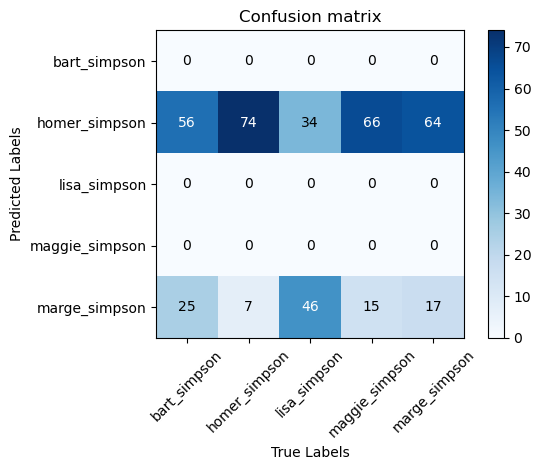

the model accuracy is  0.22524752475247525
+----------------+-----------+--------+-------------+-------+
|                | Precision | Recall | Specificity |   F1  |
+----------------+-----------+--------+-------------+-------+
|  bart_simpson  |    0.0    |  0.0   |     1.0     |  0.0  |
| homer_simpson  |   0.252   | 0.914  |    0.319    | 0.395 |
|  lisa_simpson  |    0.0    |  0.0   |     1.0     |  0.0  |
| maggie_simpson |    0.0    |  0.0   |     1.0     |  0.0  |
| marge_simpson  |   0.155   |  0.21  |    0.712    | 0.178 |
+----------------+-----------+--------+-------------+-------+


In [188]:
from tqdm import tqdm
import math
def pre_function(img):
    # img = im.open('test.jpg')
    # img = np.array(img).astype(np.float32)
    img = img / 255.
    img = (img - 0.5) * 2.0
    return img


# data generator with data augmentation
validation_image_generator = ImageDataGenerator(preprocessing_function=pre_function)

val_data_gen = validation_image_generator.flow_from_directory(directory=test_dir,
                                                              batch_size=batch_size,
                                                              shuffle=False,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical')
# img, _ = next(train_data_gen)
total_val = val_data_gen.n
confusion = ConfusionMatrix(num_classes=NB_CLASS, labels=labels)

# validate
for step in tqdm(range(math.ceil(total_val / batch_size))):
    val_images, val_labels = next(val_data_gen)
    results = from_model.predict_on_batch(val_images)
    results = tf.keras.layers.Softmax()(results).numpy()
    results = np.argmax(results, axis=-1)
    labels1 = np.argmax(val_labels, axis=-1)
    confusion.update(results, labels1)
confusion.plot()
confusion.summary()